In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from xgboost import plot_importance, XGBClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from time import time
import seaborn as sns

from tensorflow.keras.layers import (Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten,
                                     GlobalMaxPooling2D, LeakyReLU, concatenate, Dropout)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD,RMSprop,Adam

In [2]:
SEED=42
from numpy.random import seed
from tensorflow import random
seed(SEED)
random.set_seed(SEED)

In [3]:
X = np.load('../project1/X.npy')
Y = np.load('../project1/Y.npy')

In [4]:
Ydf = DataFrame(data=Y, columns=[9,0,7,6,1,8,4,3,2,5])
Ydf = Ydf[[x for x in range(10)]].to_numpy()
#Ydf = Y
#Ydf['class']='C' + (Ydf[range(10)].idxmax(axis=1)).astype('str')
#Ydf[['class']]
#Y2 = Ydf[['class']].to_numpy()

In [5]:
Ydf

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [7]:
X.shape

(2062, 64, 64, 1)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Ydf, test_size=0.1, random_state=SEED)

In [9]:
train_datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1,
                                   width_shift_range=4, height_shift_range=4)
train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=50,
        shuffle=False,
        seed=42)

In [10]:
def create_model(filters=[8,16,4], weights=[64,32], input_shape=(64,64,1), dropout=0.1):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    for filter in filters:
        model.add(Conv2D(filter, (3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(dropout))
     
    for weight in weights:
        model.add(Dense(weight))
        model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [11]:
loss='categorical_crossentropy'
#LEARNING_RATE = 0.05
BATCH_SIZE = X_train.shape[0]//20 # computing the loss over the whole dataset
EPOCHS = 300
model = create_model()
model.compile(loss=loss, optimizer='nadam', metrics=['acc'],)# metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 4)         5

In [12]:
t0 = time()
train_generator.batch_size=BATCH_SIZE
history = model.fit_generator(train_generator, validation_data=(X_valid, y_valid), epochs=EPOCHS, verbose=1)
# history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
print (time()-t0)

Epoch 1/300
21/21 [==============================] - 3s 130ms/step - loss: 2.3012 - acc: 0.1294 - val_loss: 2.2893 - val_acc: 0.2029
Epoch 2/300
21/21 [==============================] - 3s 122ms/step - loss: 2.2786 - acc: 0.1709 - val_loss: 2.2471 - val_acc: 0.1304
Epoch 3/300
21/21 [==============================] - 3s 130ms/step - loss: 2.1443 - acc: 0.2334 - val_loss: 1.9095 - val_acc: 0.4155
Epoch 4/300
21/21 [==============================] - 3s 123ms/step - loss: 1.7512 - acc: 0.4059 - val_loss: 1.5151 - val_acc: 0.4976
Epoch 5/300
21/21 [==============================] - 3s 124ms/step - loss: 1.4428 - acc: 0.5024 - val_loss: 1.3023 - val_acc: 0.5314
Epoch 6/300
21/21 [==============================] - 3s 119ms/step - loss: 1.3027 - acc: 0.5542 - val_loss: 1.1100 - val_acc: 0.6473
Epoch 7/300
21/21 [==============================] - 2s 119ms/step - loss: 1.2070 - acc: 0.5984 - val_loss: 0.9156 - val_acc: 0.7053
Epoch 8/300
21/21 [==============================] - 3s 127ms/step - 

21/21 [==============================] - 3s 124ms/step - loss: 0.2891 - acc: 0.8987 - val_loss: 0.1566 - val_acc: 0.9469
Epoch 63/300
21/21 [==============================] - 3s 127ms/step - loss: 0.2761 - acc: 0.9062 - val_loss: 0.1462 - val_acc: 0.9614
Epoch 64/300
21/21 [==============================] - 3s 129ms/step - loss: 0.2427 - acc: 0.9224 - val_loss: 0.1816 - val_acc: 0.9372
Epoch 65/300
21/21 [==============================] - 3s 127ms/step - loss: 0.2650 - acc: 0.9094 - val_loss: 0.1326 - val_acc: 0.9517
Epoch 66/300
21/21 [==============================] - 3s 126ms/step - loss: 0.2340 - acc: 0.9245 - val_loss: 0.1617 - val_acc: 0.9420
Epoch 67/300
21/21 [==============================] - 4s 186ms/step - loss: 0.2420 - acc: 0.9197 - val_loss: 0.1349 - val_acc: 0.9614
Epoch 68/300
21/21 [==============================] - 5s 230ms/step - loss: 0.2386 - acc: 0.9202 - val_loss: 0.1299 - val_acc: 0.9517
Epoch 69/300
21/21 [==============================] - 5s 225ms/step - loss:

21/21 [==============================] - 3s 127ms/step - loss: 0.1106 - acc: 0.9547 - val_loss: 0.0523 - val_acc: 0.9903
Epoch 124/300
21/21 [==============================] - 3s 122ms/step - loss: 0.1164 - acc: 0.9601 - val_loss: 0.0805 - val_acc: 0.9710
Epoch 125/300
21/21 [==============================] - 3s 121ms/step - loss: 0.1444 - acc: 0.9542 - val_loss: 0.0702 - val_acc: 0.9758
Epoch 126/300
21/21 [==============================] - 3s 120ms/step - loss: 0.1134 - acc: 0.9617 - val_loss: 0.0620 - val_acc: 0.9855
Epoch 127/300
21/21 [==============================] - 3s 121ms/step - loss: 0.1205 - acc: 0.9590 - val_loss: 0.0465 - val_acc: 0.9855
Epoch 128/300
21/21 [==============================] - 3s 120ms/step - loss: 0.1253 - acc: 0.9580 - val_loss: 0.0559 - val_acc: 0.9903
Epoch 129/300
21/21 [==============================] - 3s 123ms/step - loss: 0.1092 - acc: 0.9606 - val_loss: 0.0498 - val_acc: 0.9903
Epoch 130/300
21/21 [==============================] - 3s 121ms/step 

Epoch 184/300
21/21 [==============================] - 2s 118ms/step - loss: 0.0956 - acc: 0.9704 - val_loss: 0.0363 - val_acc: 0.9855
Epoch 185/300
21/21 [==============================] - 2s 117ms/step - loss: 0.0906 - acc: 0.9730 - val_loss: 0.0349 - val_acc: 0.9807
Epoch 186/300
21/21 [==============================] - 3s 139ms/step - loss: 0.0937 - acc: 0.9660 - val_loss: 0.0443 - val_acc: 0.9903
Epoch 187/300
21/21 [==============================] - 3s 132ms/step - loss: 0.0857 - acc: 0.9704 - val_loss: 0.0284 - val_acc: 0.9903
Epoch 188/300
21/21 [==============================] - 3s 123ms/step - loss: 0.0861 - acc: 0.9741 - val_loss: 0.0317 - val_acc: 0.9903
Epoch 189/300
21/21 [==============================] - 3s 123ms/step - loss: 0.0719 - acc: 0.9768 - val_loss: 0.0334 - val_acc: 0.9855
Epoch 190/300
21/21 [==============================] - 3s 124ms/step - loss: 0.0790 - acc: 0.9757 - val_loss: 0.0268 - val_acc: 0.9903
Epoch 191/300
21/21 [==============================] - 

Epoch 245/300
21/21 [==============================] - 3s 124ms/step - loss: 0.0487 - acc: 0.9817 - val_loss: 0.0240 - val_acc: 0.9952
Epoch 246/300
21/21 [==============================] - 3s 139ms/step - loss: 0.0588 - acc: 0.9790 - val_loss: 0.0256 - val_acc: 0.9952
Epoch 247/300
21/21 [==============================] - 3s 121ms/step - loss: 0.0498 - acc: 0.9865 - val_loss: 0.0195 - val_acc: 0.9952
Epoch 248/300
21/21 [==============================] - 3s 123ms/step - loss: 0.0604 - acc: 0.9774 - val_loss: 0.0233 - val_acc: 0.9903
Epoch 249/300
21/21 [==============================] - 2s 118ms/step - loss: 0.0685 - acc: 0.9774 - val_loss: 0.0221 - val_acc: 1.0000
Epoch 250/300
21/21 [==============================] - 3s 121ms/step - loss: 0.0514 - acc: 0.9833 - val_loss: 0.0232 - val_acc: 0.9903
Epoch 251/300
21/21 [==============================] - 3s 132ms/step - loss: 0.0585 - acc: 0.9801 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 252/300
21/21 [==============================] - 

In [13]:
def plot_history(history, metrics=['loss'], val=False, shape=None, logy=False):
    if not isinstance(logy, list):
        logy = [logy] * len(metrics)
    df = DataFrame(history.history)
    if shape is None:
        shape = (1,len(metrics))
    for i, metric in enumerate(metrics):
        cols = [metric]
        if val:
            cols.append('val_' + metric)
        ax = plt.subplot(shape[0],shape[1],i+1)
        df[cols].plot(ax=ax, logy=logy[i])
        plt.grid(True)
        plt.xlabel('epoch')
    plt.show()

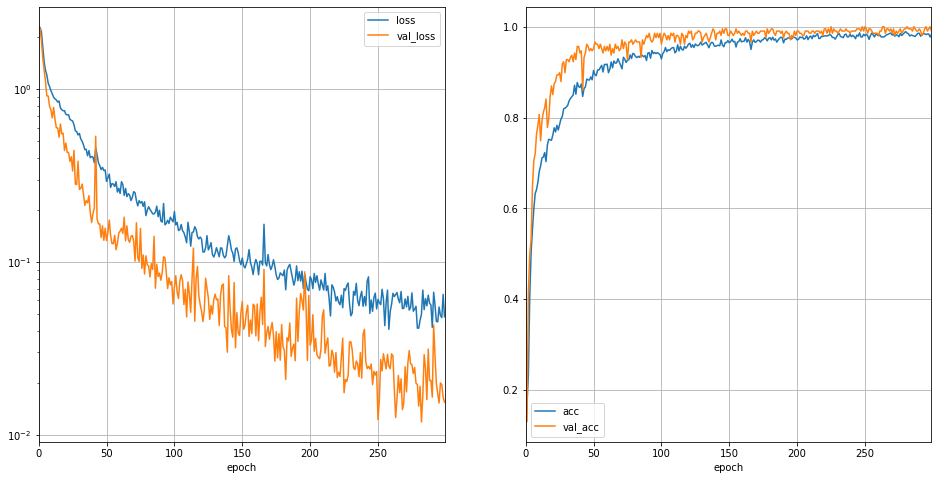

In [14]:
fig = plt.figure(figsize=(16, 8))
plot_history(history, metrics=['loss','acc'], val=True, logy=[True,False])

In [15]:
y_pred = model.predict(X_valid)

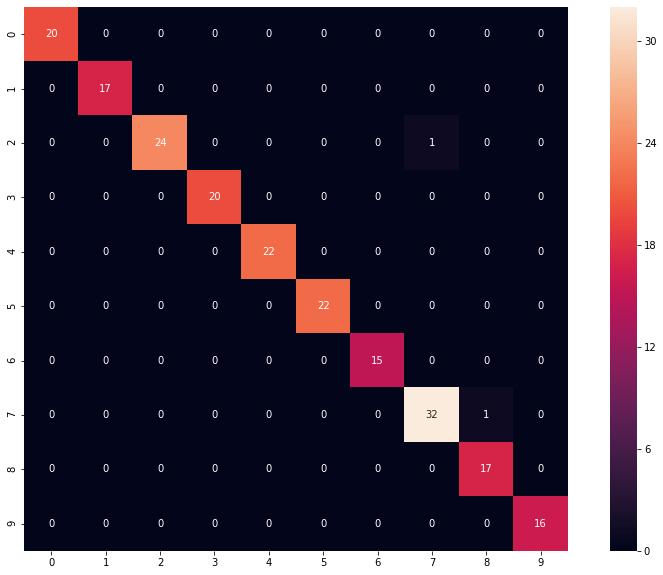

Accuracy= 0.9903381642512077


In [16]:
y_valid_class = y_valid.argmax(axis=1)
y_pred_class = y_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_valid_class, y_pred_class)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print('Accuracy=', accuracy_score(y_valid_class, y_pred_class))

In [17]:
y_pred[0]

array([1.2736270e-07, 8.1289472e-12, 1.7483566e-13, 1.0600380e-12,
       9.9770373e-01, 1.9313631e-10, 2.1042451e-03, 1.6024536e-04,
       3.1405903e-05, 3.7402432e-07], dtype=float32)

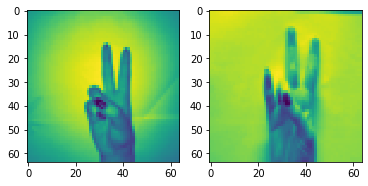

[2 7]
[7 8]


In [19]:
errors = X_valid[y_valid_class != y_pred_class]
for i, img in enumerate(errors):
    plt.subplot(1, errors.shape[0], i+1)
    plt.imshow(img.reshape(64,64))
plt.show()
print(y_valid[y_valid_class != y_pred_class].argmax(axis=1))
print(y_pred[y_valid_class != y_pred_class].argmax(axis=1))